In [1]:
import os
import sys
from pathlib import Path
import json
from collections import defaultdict
import numpy as np
import multiprocessing
import mne

from vr2fem_analyses.staticinfo import PATHS, CONFIG
from vr2fem_analyses import helpers


In [2]:
def get_data(subID, picks="eeg"):
    paths = PATHS()
    path_in = Path(paths.DATA_03_AR, "cleaneddata")
    fname = Path(path_in, f"{subID}-postAR-epo.fif")
    epos = mne.read_epochs(fname, verbose=False).pick(picks)
    times = epos.times
    info = epos.info

    return epos, times, info


In [3]:
# load data
paths = PATHS()
path_in = Path(paths.DATA_03_AR, "cleaneddata")
sub_list_str = [s.split("-postAR-epo")[0] for s in os.listdir(path_in)]
epos = []
evos = []
for sub in sub_list_str:
    ee = get_data(sub)
    epos.append(ee)


In [27]:
emotions = ["happy", "angry", "neutral", "surprised"]

evos = defaultdict(dict)
evos_ga = defaultdict(dict)
for vc in ['stereo', 'mono', '']:
    for emo in emotions:
        evos[emo] = []
        for sub in epos:
            evos[emo].append(sub[0][emo].average())
        evos_ga[emo] = mne.grand_average(evos[emo])

        if vc == '':
            continue
        evos[vc][emo] = []
        for sub in epos:
            evos[vc][emo].append(sub[0][vc + '/' + emo].average())
        evos_ga[vc][emo] = mne.grand_average(evos[vc][emo])



Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


In [37]:

# calc differences to neutral for all emotions

evos_diff = defaultdict(dict)
evos_diff_ga = defaultdict(dict)
for vc in ['stereo', 'mono', '']:
    for emo in emotions:
        evos_diff[emo] = []
        for sub in epos:
            evos_diff[emo].append(mne.combine_evoked(
                [sub[0][emo].average(), sub[0]["neutral"].average()],
                weights=[1, -1])
                )
        evos_diff_ga[emo] = mne.grand_average(evos_diff[emo])

        if vc == '':
            continue
        evos_diff[vc][emo] = []
        for sub in epos:
            evos_diff[vc][emo].append(mne.combine_evoked(
                [sub[0][vc + '/' + emo].average(), sub[0][vc + '/' + "neutral"].average()],
                weights=[1, -1])
                )
        evos_diff_ga[vc][emo] = mne.grand_average(evos_diff[vc][emo])
            

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


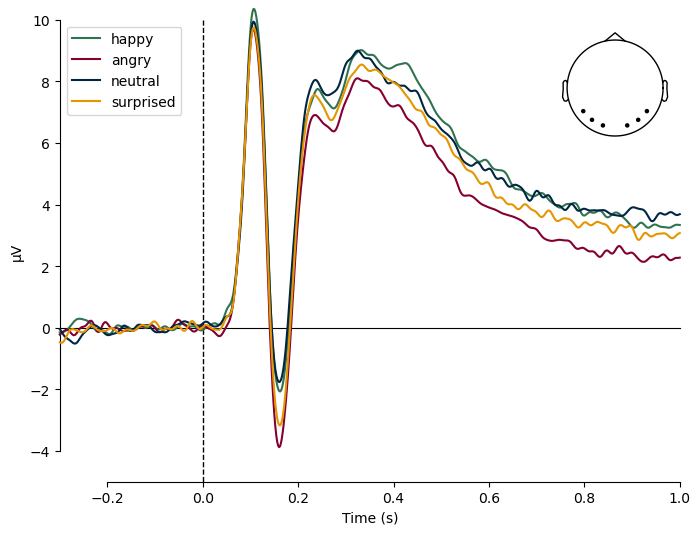

In [19]:
colors = dict()
colors["happy"] = "#307351"
colors["angry"] = "#840032"
colors["neutral"] = "#002642"
colors["surprised"] = "#E59500"

picks = dict()
picks["EPN"] = ["P7", "PO7", "O1", "P8", "PO8", "O2"]
p = mne.viz.plot_compare_evokeds(evos_ga,
                                 picks=picks["EPN"],
                                 show=True,
                                 combine='mean',
                                 ylim=dict(eeg=[-5, 10]),
                                 title="",
                                 colors=colors,
                                 show_sensors="upper right",
                                )       


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


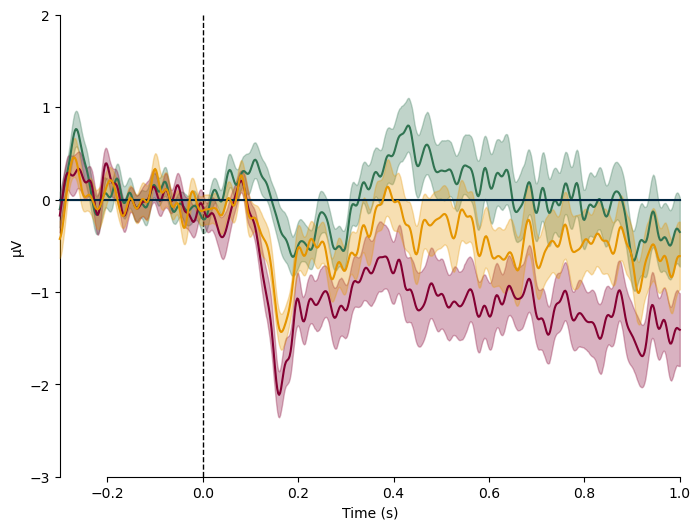

In [23]:
p = mne.viz.plot_compare_evokeds(evos_diff,
                                 picks=picks["EPN"],
                                 show=True,
                                 combine='mean',
                                 ylim=dict(eeg=[-3, 2]),
                                 title="",
                                 colors=colors,
                                 legend=False,
                                 ci=0.68,
                                )       


combining channels using "mean"
combining channels using "mean"


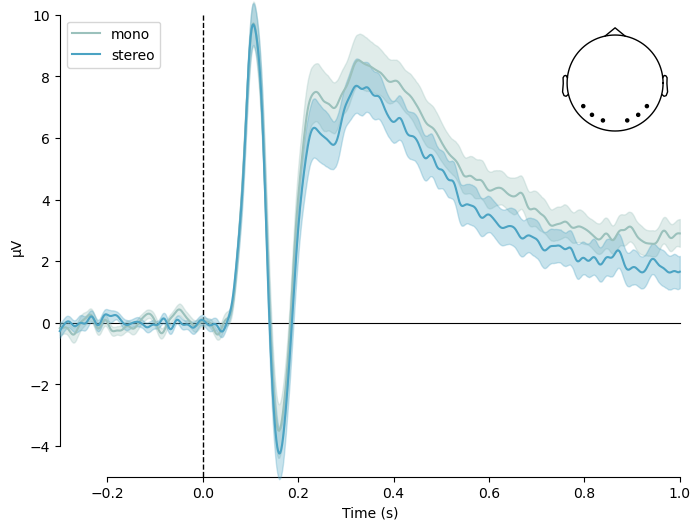

combining channels using "mean"
combining channels using "mean"


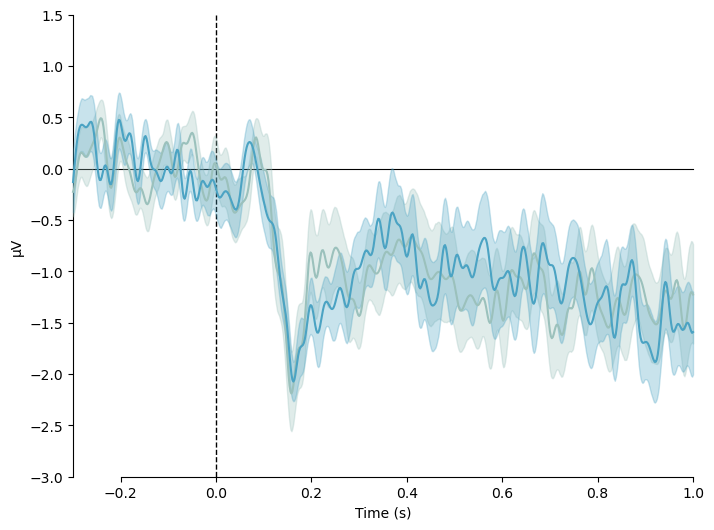

In [47]:
colors = dict()
# colors["happy"] = "#307351"
# colors["angry"] = "#840032"
# colors["neutral"] = "#002642"
# colors["surprised"] = "#E59500"
colors["stereo"] = "#4BA3C3"
colors["mono"] = "#9BC1BC"

picks = dict()
picks["EPN"] = ["P7", "PO7", "O1", "P8", "PO8", "O2"]

emo_showcase = "angry"

p = mne.viz.plot_compare_evokeds({'mono': evos['mono'][emo_showcase],
                                    'stereo': evos['stereo'][emo_showcase]},
                                 picks=picks["EPN"],
                                 show=True,
                                 combine='mean',
                                 ylim=dict(eeg=[-5, 10]),
                                 title="",
                                 colors=colors,
                                 ci=0.68,
                                 show_sensors="upper right",
                                )    

p = mne.viz.plot_compare_evokeds({'mono': evos_diff['mono'][emo_showcase],
                                    'stereo': evos_diff['stereo'][emo_showcase]},
                                 picks=picks["EPN"],
                                 show=True,
                                 combine='mean',
                                 ylim=dict(eeg=[-3, 1.5]),
                                 title="",
                                 colors={c: colors[c] for c in ['mono', 'stereo']},
                                 legend=False,
                                 ci=0.68,
                                )   

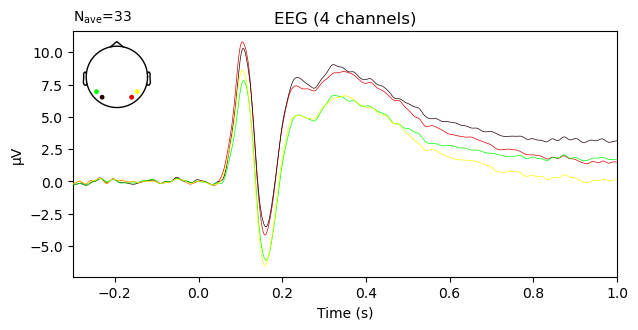

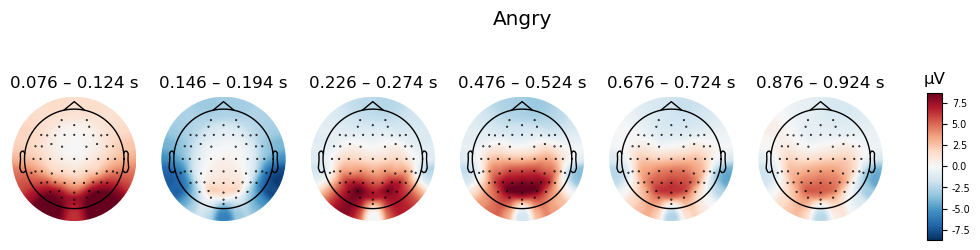

No projector specified for this dataset. Please consider the method self.add_proj.


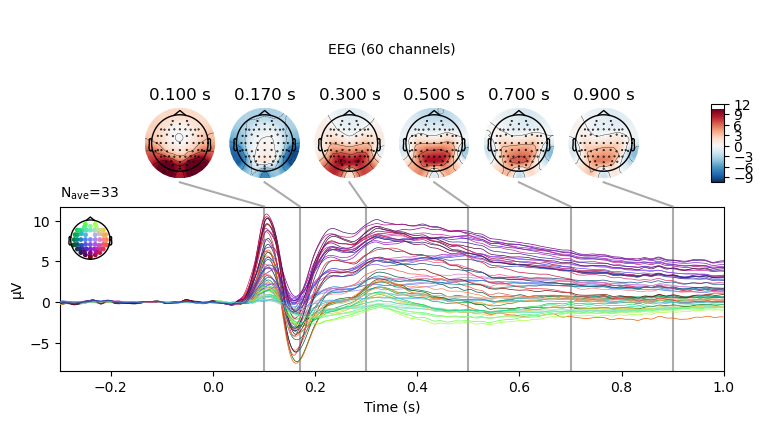

In [9]:
emo_target = "angry"
p = evos_ga[emo_target].plot(
    spatial_colors=True, gfp=False, time_unit="s", picks=["PO8", "PO7", "P7", "P8"]
)
P = evos_ga[emo_target].plot_topomap(
    times=[0.1, 0.170, 0.250, 0.5, 0.7, 0.9],
    time_unit="s",
    average=0.05,
    colorbar=True,
    outlines="skirt",
    contours=0,
    show_names=False,
    title="Angry",
)
p = evos_ga[emo_target].plot_joint(times=[0.1, 0.170, 0.300, 0.5, 0.7, 0.9])


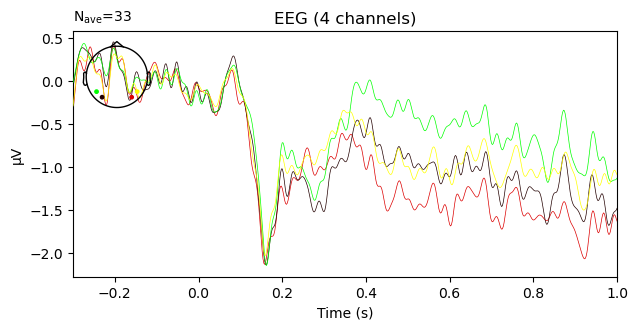

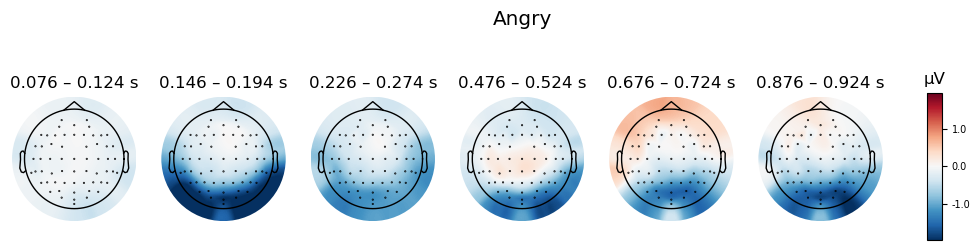

No projector specified for this dataset. Please consider the method self.add_proj.


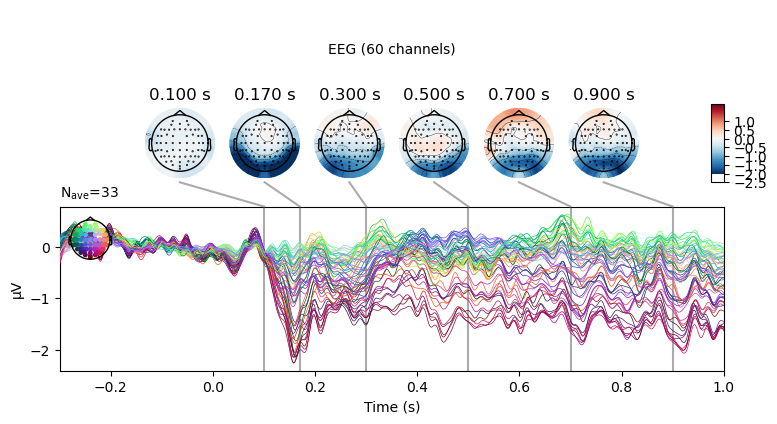

In [12]:
P = evos_diff_ga[emo_target].plot(
    spatial_colors=True, gfp=False, time_unit="s", picks=["PO8", "PO7", "P7", "P8"]
)
p = evos_diff_ga[emo_target].plot_topomap(
    times=[0.1, 0.170, 0.250, 0.5, 0.7, 0.9],
    time_unit="s",
    average=0.05,
    colorbar=True,
    outlines="skirt",
    contours=0,
    show_names=False,
    title="Angry",
)
p = evos_diff_ga[emo_target].plot_joint(
    times=[0.1, 0.170, 0.300, 0.5, 0.7, 0.9]
)


In [15]:
picks = ["Oz", "POz", "PO3", "PO4", "O1", "O2", "PO7", "PO8"]
# mne.viz.plot_compare_evokeds([evos["angry"], evos["neutral"]], show_sensors="upper right", combine='mean')

diff = mne.combine_evoked([evos["angry"], evos["neutral"]], weights=[1, -1])


AttributeError: 'list' object has no attribute 'nave'

In [44]:
view_conds = ["mono", "stereo"]
for vc in view_conds:
    evos[vc] = []
    for sub in epos:
        evos[vc].append(sub[0][vc].average())


More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


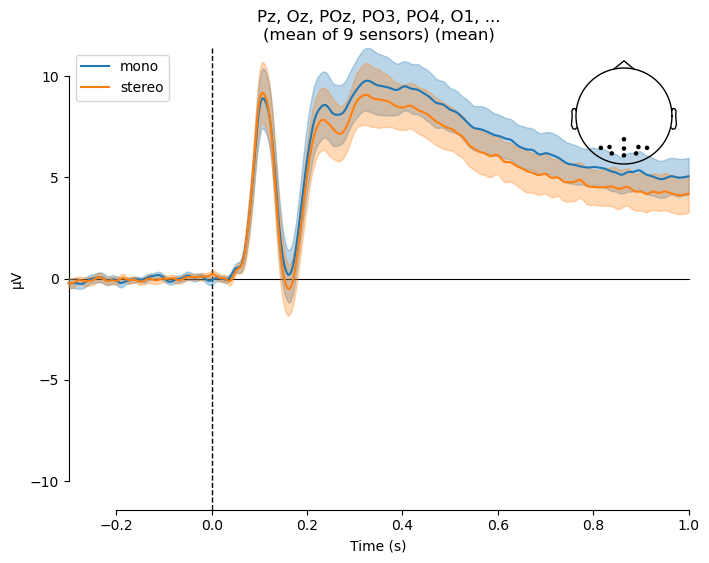

[<Figure size 800x600 with 2 Axes>]

In [45]:
evos_vc = {vc: evos[vc] for vc in view_conds}
mne.viz.plot_compare_evokeds(
    evos_vc, show_sensors="upper right", combine="mean", picks=picks, ci=True
)


TypeError: object of type 'EvokedArray' has no len()